# Project 🚗 Vehicle Silhouette Classification

## Problem Statement


Prospect Auto aims to develop a model that assigns vehicles to one of three vehicle classes based on silhouette data.

The classification should be performed using numerical features derived from the image data.

The goal is to train a machine learning model to solve this task as a supervised classification problem. A structured dataset is available for this purpose, containing both the input features and the target class.


## Import Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

## Import the CSV file and examine the data structure

In [79]:
raw_data = pd.read_csv("vehicle.csv")
df = raw_data.copy()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

## Visual Analysis of the Dataset

### **Distribution of Target Classes**

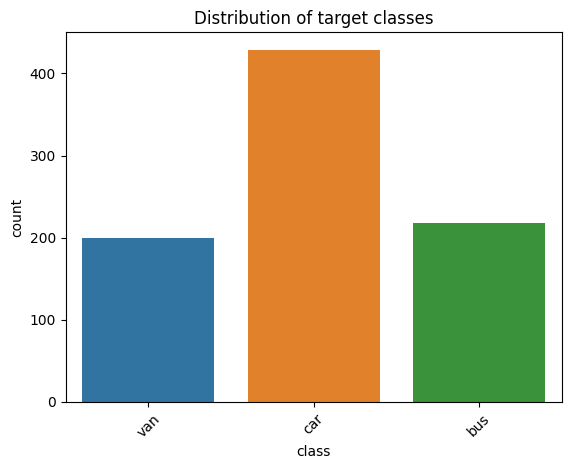

In [80]:
# Color coding of the classes
class_colors = {
    "van": "#1f77b4",   # blau
    "car": "#ff7f0e",   # orange
    "bus": "#2ca02c",   # grün
}

order = ["van", "car", "bus"]

colors = [class_colors[cls] for cls in order]

sns.countplot(data=df, x="class", hue="class", order=order, palette=class_colors, legend=False)
plt.title("Distribution of target classes")
plt.xticks(rotation=45)
plt.show()



**Insights:**<br>

The class *car* accounts for by far the largest share in the dataset, representing about 50% of the total distribution. The classes *van* and *bus* are significantly less represented and together make up the other half, with *bus* having a slight majority. Overall, there is a moderate class imbalance that should be considered during modeling.

A possible effect of this distribution is that a model may tend to favor the dominant class *car*. As a result, the smaller classes (*van* and *bus*) could be recognized less accurately. To counter this, the option `class_weight="balanced"` can be used during model training. This weights the classes according to their frequency, ensuring that less represented classes are properly considered. Especially when evaluating the model, metrics such as precision, recall, and the F1 score should be considered in addition to accuracy to obtain a fair assessment of the model's quality.

### **Distribution of Features by Target Classes**

#### - Pairplot

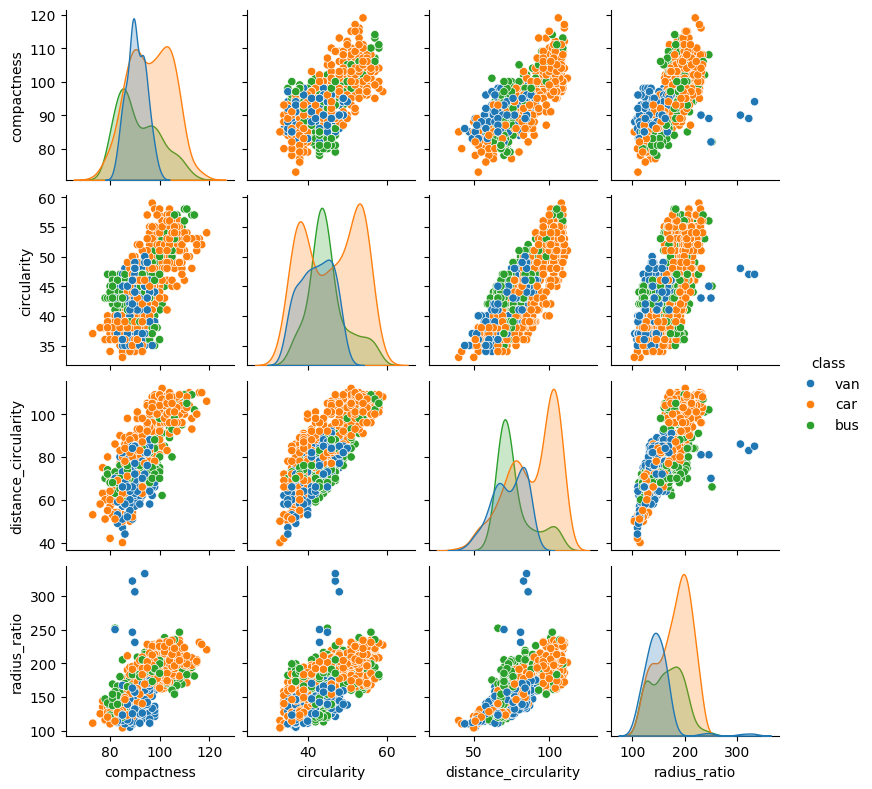

In [81]:
subset_cols = df.columns[:4].tolist() + ["class"]
sns.pairplot(df[subset_cols], hue="class",  height=2.0, aspect=1)
plt.show()


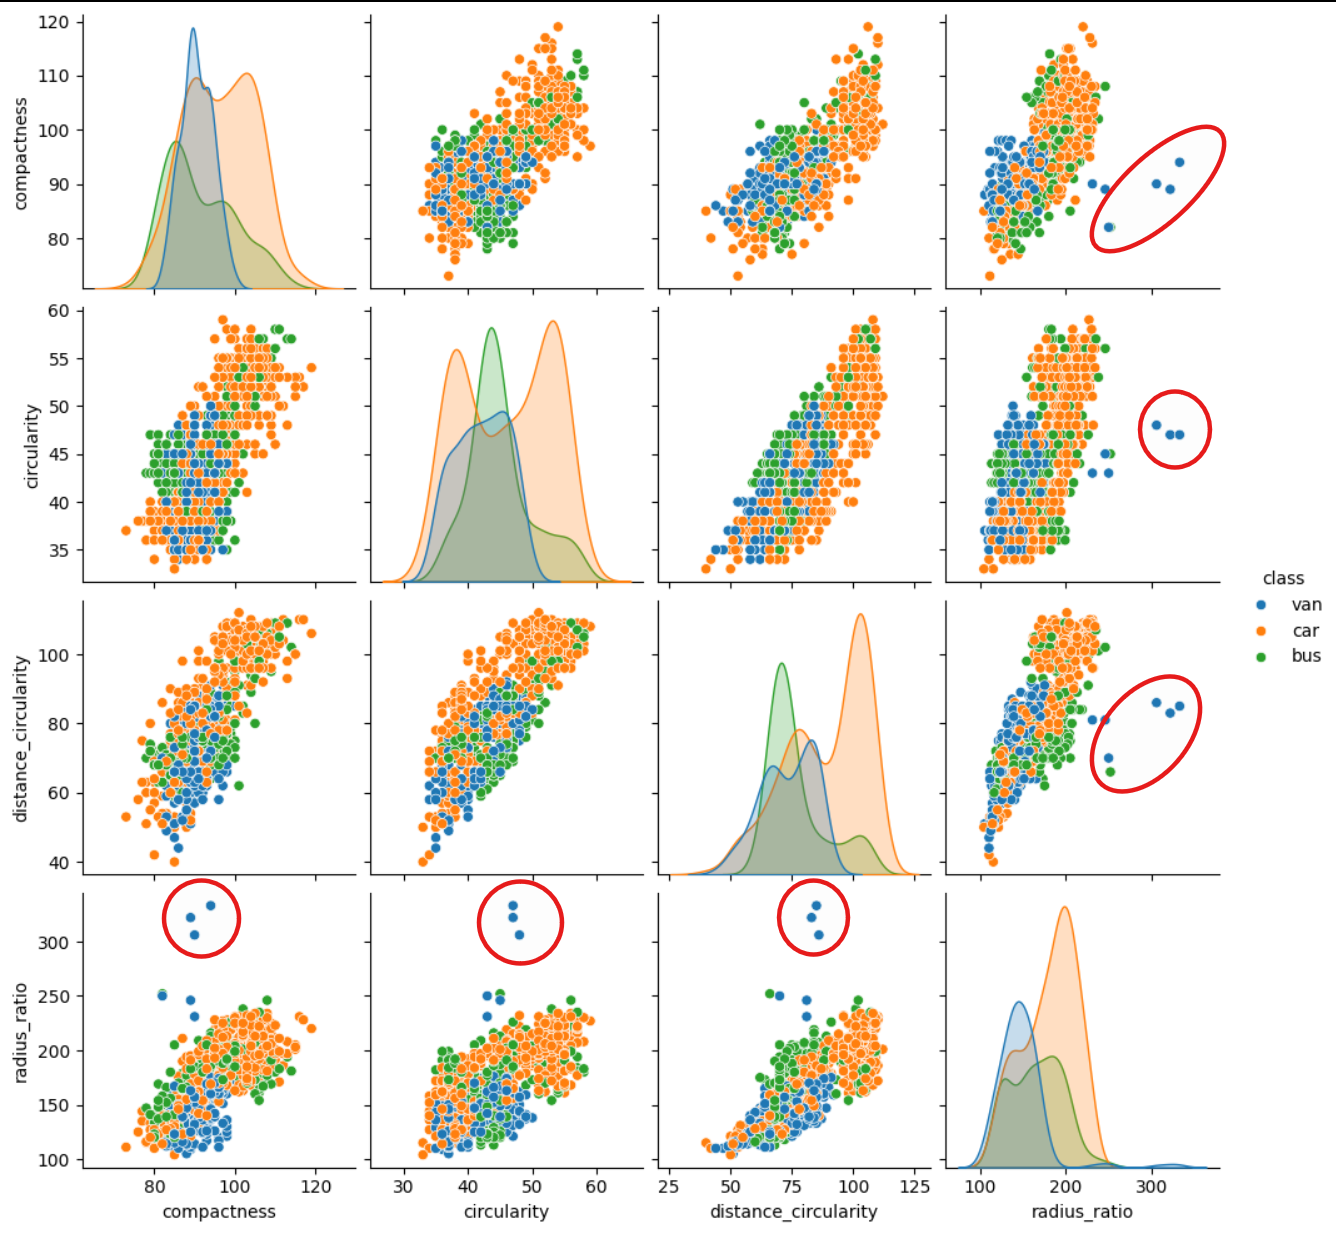

In [82]:
from IPython.display import Image
Image(filename="distribution_analysis_plot.png", width=870)  # Breite in Pixeln

**Insights**

The pairplot shows how the different features behave in relation to the target class. At first glance, it is noticeable that some classes can be well separated in specific feature combinations. For example, with *compactness* combined with other features, dense clusters of points form, where the *van* class clearly stands out — the points are concentrated in a narrow range and barely mix with *car* or *bus*.

This becomes especially clear in the combination of *radius_ratio* vs. *compactness* or *circularity*. In these cases, individual *van* points appear outside the main point clusters — potential outliers that are visually easy to spot. Such outliers are visible across multiple axes and should be examined in more detail before model training to decide whether they should be removed or treated specially.

The diagonal density curves also show how the classes are distributed within individual features. For *compactness*, it is clearly visible that *van* is very tightly clustered, while *car* shows a wider distribution.

Some feature combinations also display very clear linear patterns — for example, between *compactness* and *circularity* or *distance_circularity* and *radius_ratio*. This indicates strong correlations that should be considered later during feature selection to avoid redundancy.

In summary, the pairplot helps to gain initial visual impressions: which classes cluster closely in which feature spaces, where clear separations exist, and where points may fall outside the pattern.

#### - Heatmap

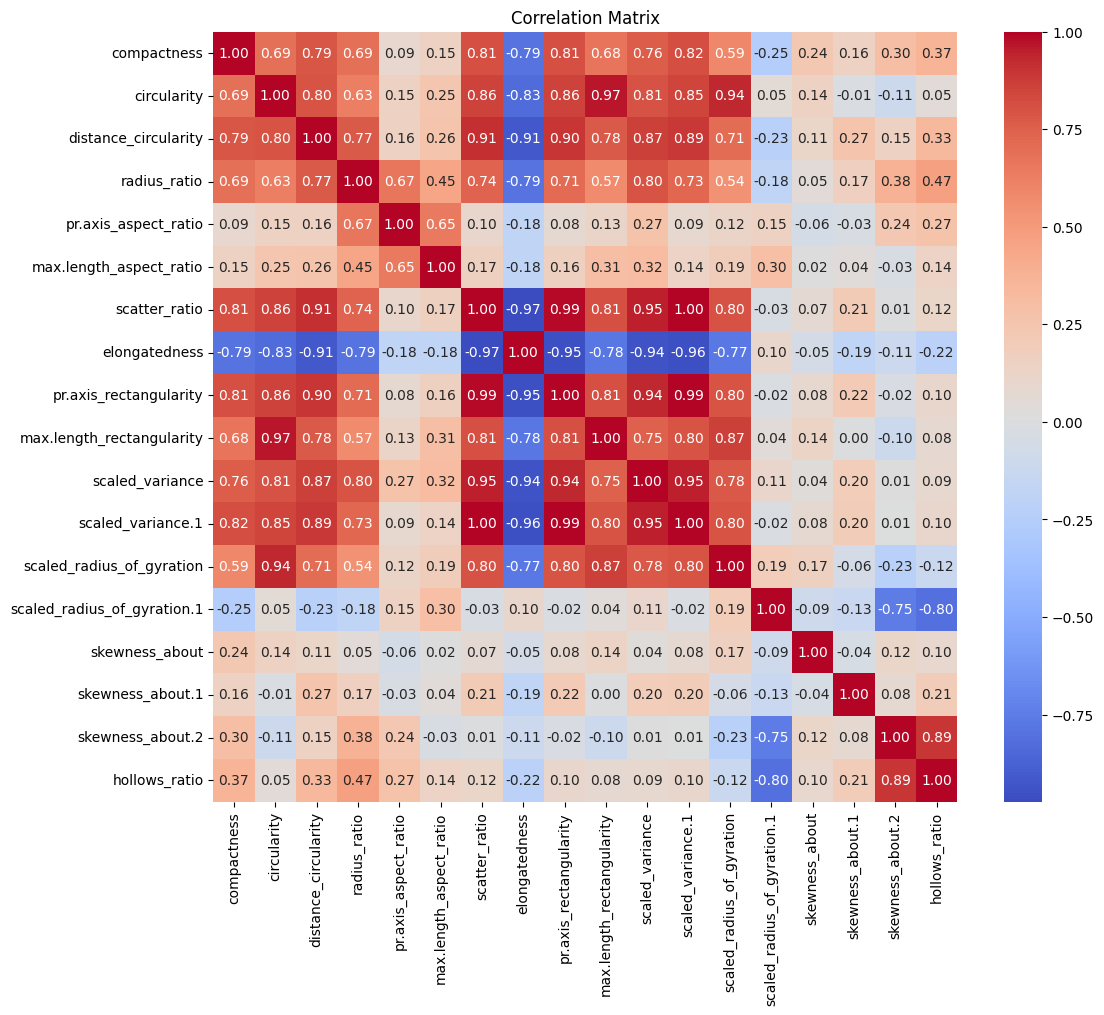

In [83]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


**Insights**<br>

When examining the correlation matrix, I noticed that some features are highly correlated with each other. For example, there is a strong correlation between `max.length_rectangularity` and `circularity`, as well as between `scaled_variance` and `scaled_variance.1`. Although these features are not exact duplicates, they provide almost the same information. This can cause problems during modeling because the model might double-count certain information (multicollinearity).

Another interesting feature is `elongatedness`, which shows a strong negative correlation with many other features. This means that as `elongatedness` increases, many other values decrease simultaneously — it often behaves inversely.

For the next step in modeling, it makes sense to consider which features are truly necessary. In groups of very similar features, it is often sufficient to use only one. This simplifies the model, makes it more robust, and improves its ability to generalize to new data.

#### - Boxplot

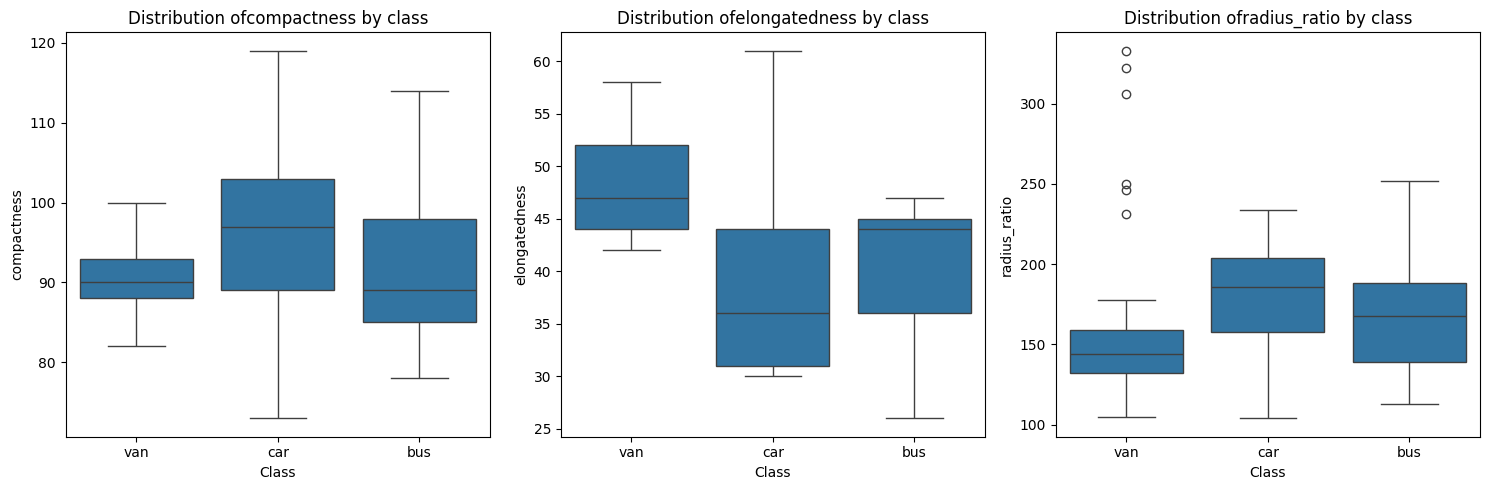

In [84]:
# Features you want to compare
features = ["compactness", "elongatedness", "radius_ratio"]

# Create subplots
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)  # 1 Zeile, 3 Spalten, i-te Position
    sns.boxplot(data=df, x="class", y=feature)
    plt.title(f"Distribution of{feature} by class")
    plt.xlabel("Class")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


**Boxplot Comparison: compactness, elongatedness, radius_ratio**<br>  
(selection based on previous plots)

***compactness***  
The values for compactness are relatively tightly clustered around 90 for the *van* class. This compact distribution suggests low variance and indicates that *van* shows a clearly identifiable structure for this feature. In comparison, *car* and *bus* are much more widely distributed. Particularly, *car* has a higher median, meaning vehicles in this class tend to show higher compactness. *Bus* has a median similar to *van* but a much broader spread, resulting in stronger overlap with the other classes. Overall, compactness appears to be well-suited to distinguish *van* from the other classes.

***elongatedness***  
For elongatedness, the differences between the classes are particularly striking. *Van* shows a significantly higher median compared to *car* and *bus*, with very little overlap between the boxplot ranges. Between *van* and *car*, an almost complete separation seems possible. The separation from *bus* is also very clear, with only minimal overlap at the edges. This distinct difference makes elongatedness a valuable feature for classification. At the same time, it raises the question of whether the model might rely too heavily on this single feature. Such a dominant feature can increase training accuracy but also carries the risk of overfitting if the distribution does not remain stable in future data.

***radius_ratio***  
The distribution of radius_ratio shows several outliers with extremely high values, particularly for the *van* class. These points affect the spread and cause the overall distribution to be skewed. *Car* and *bus* are also relatively widely spread but with fewer extreme outliers. The median for *car* is the highest. Again, it is evident that *van* tends to have lower values. Although there is overlap, radius_ratio can contribute significantly to class separation when combined with other features — but it is likely not sufficient on its own.

***Overall Conclusion***  
All three features show different forms of separation potential between the classes. Elongatedness stands out for its clear distinction. Compactness is particularly useful for differentiating *van*, while radius_ratio adds important supplementary information, though it appears less robust due to outliers. These features should be closely monitored during modeling, with special attention to the risk of overfitting, particularly for elongatedness.

## Missing Values and Imputing kNN

In [85]:
df.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [86]:
from sklearn.impute import KNNImputer

labels = df["class"]
df_features = df.drop(columns="class")
df_encoded = pd.get_dummies(df_features, dummy_na=True)

imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

df_imputed['label'] = labels.reset_index(drop=True)

df_imputed.isna().sum()
print(df_imputed["label"])
print(df_imputed.isna().sum().sum())

0      van
1      van
2      car
3      van
4      bus
      ... 
841    car
842    van
843    car
844    car
845    van
Name: label, Length: 846, dtype: object
0


**ℹ️ Info**

Before starting model training, I checked whether there were any missing values in the dataset. Since machine learning models generally cannot handle missing values, it is important to address them beforehand. To supplement the data as naturally as possible, I chose the KNNImputer. This method replaces missing values with the average of similar data rows — in my case, based on the three nearest neighbors.

Since the imputer can only process numerical values, I first converted all non-numerical features using one-hot encoding. Afterward, I reattached the label to maintain the original dataset structure.

After the imputation, no missing values remained, which I verified once more. The dataset is now complete and ready for model training.

## Encoding Label Column

In [87]:
le = LabelEncoder()
df_imputed['label'] = le.fit_transform(df_imputed['label'])
print(le.classes_)



['bus' 'car' 'van']


## Spliting Training and Test Data

In [88]:
X = df_imputed.drop(columns="label")
y = df_imputed["label"]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=500, random_state=42)

## Model DecisionTreeClassifier

In [89]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [90]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 86.00 %
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       140
           1       0.87      0.90      0.89       240
           2       0.84      0.72      0.78       120

    accuracy                           0.86       500
   macro avg       0.86      0.84      0.85       500
weighted avg       0.86      0.86      0.86       500



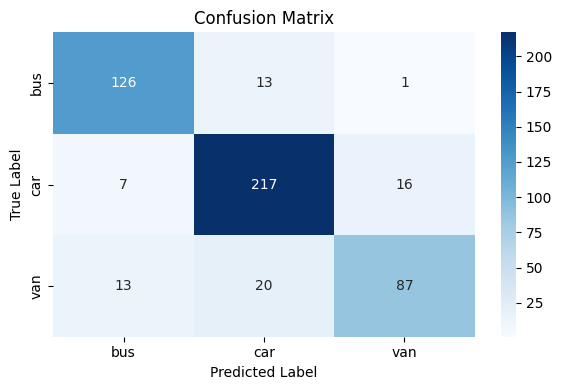

In [91]:
# Retrieve class labels from the LabelEncoder if not already available
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model Random Forest Classifier 

In [92]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 95.00 %
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       140
           1       0.95      0.97      0.96       240
           2       0.94      0.88      0.91       120

    accuracy                           0.95       500
   macro avg       0.95      0.94      0.95       500
weighted avg       0.95      0.95      0.95       500



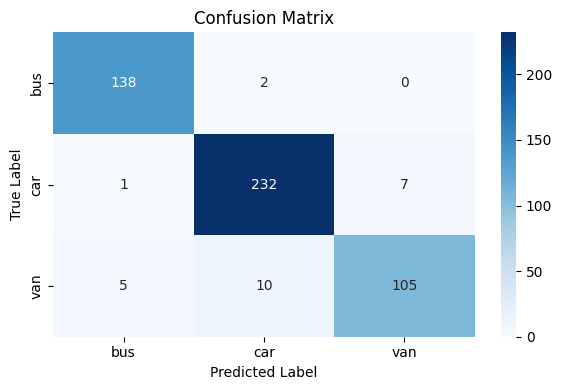

In [94]:
# Retrieve class labels from the LabelEncoder if not yet available
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model SVM

In [95]:
from sklearn.svm import SVC


model = SVC(kernel="rbf", class_weight="balanced", random_state=42)

model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [96]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 62.80 %
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       140
           1       0.82      0.56      0.67       240
           2       0.58      0.64      0.61       120

    accuracy                           0.63       500
   macro avg       0.63      0.64      0.62       500
weighted avg       0.67      0.63      0.63       500



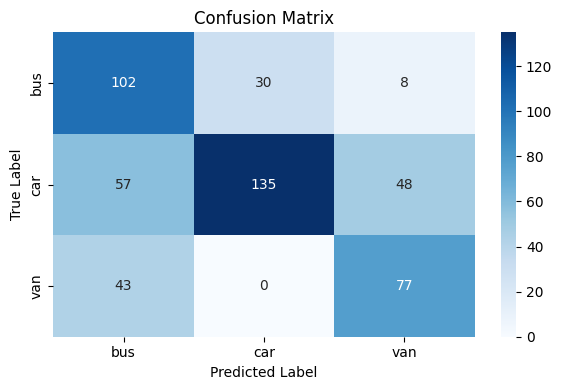

In [97]:
# Get class labels from the LabelEncoder if not yet available
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [98]:
print(X_train.isna().sum().sum())  # Anzahl fehlender Werte im Training
print(X_test.isna().sum().sum())   # im Testset


0
0


In [99]:
from sklearn.svm import SVC


model = SVC(kernel="rbf", class_weight="balanced", random_state=42)

model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [100]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)

The accuracy_score is: 62.80 %
              precision    recall  f1-score   support

           0       0.50      0.73      0.60       140
           1       0.82      0.56      0.67       240
           2       0.58      0.64      0.61       120

    accuracy                           0.63       500
   macro avg       0.63      0.64      0.62       500
weighted avg       0.67      0.63      0.63       500



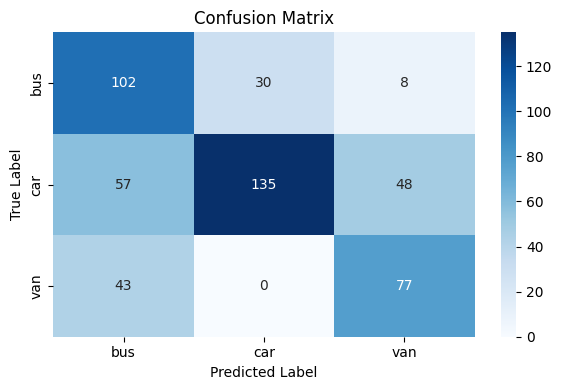

In [101]:
# Fetch class labels from the LabelEncoder if not yet available
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model Logistic Regression (Best Result)

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Step 1: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Step 2: Define model
model = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

# Step 3: Train model with scaled data
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [103]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Scale test data
X_test_scaled = scaler.transform(X_test)

# Predict with scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

print(f"The accuracy_score is: {acc * 100:.2f} %")
print(clf)


The accuracy_score is: 94.40 %
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       140
           1       0.98      0.91      0.95       240
           2       0.93      0.97      0.95       120

    accuracy                           0.94       500
   macro avg       0.94      0.95      0.94       500
weighted avg       0.95      0.94      0.94       500



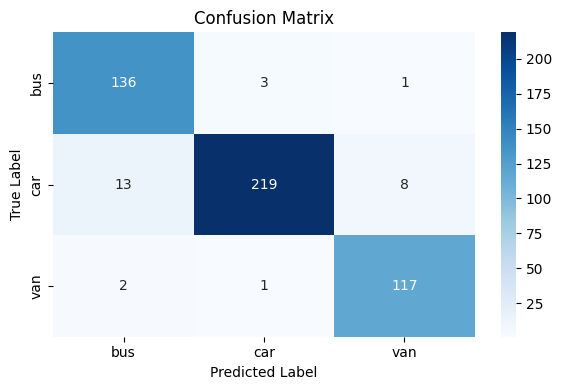

In [104]:
# Retrieve class labels from the LabelEncoder if not already retrieved
class_names = le.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Multimodel - Autoselect with Prior Adjustment

In [105]:
# 📦 Import Libraries
import pandas as pd
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# 📚 I remove redundant features and prepare X and y
drop_features = [
    "scaled_variance.1",
    "max.length_rectangularity",
    "distance_circularity"
]

# My feature set and label set based on the cleaned data
X_reduced = df_imputed.drop(columns=drop_features + ["label"])
y_reduced = df_imputed["label"]

# 📤 I split the data into training and test sets (500 samples in the test set)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_reduced, test_size=500, random_state=42
)

# 🔄 I scale the data for models that benefit from it (SVC, Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📦 Models I want to test
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "SVC": SVC(kernel="rbf", class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
}

# 🛠️ Function to train and evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    results = []

    for name, model in models.items():
        start = time.time()

        # SVC and Logistic Regression require scaled data
        if name in ["SVC", "Logistic Regression"]:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        end = time.time()

        # I measure accuracy, F1 score, and training time
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        duration = end - start

        results.append({
            "Model": name,
            "Accuracy": round(acc * 100, 2),
            "F1 (macro)": round(f1, 4),
            "Train Time (s)": round(duration, 3)
        })

    return pd.DataFrame(results)

# 🚀 I perform the model evaluation
results_df = evaluate_models(models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# 📊 I sort the results by F1 score to see the best models
print(results_df.sort_values(by="F1 (macro)", ascending=False))


                 Model  Accuracy  F1 (macro)  Train Time (s)
2  Logistic Regression      92.4      0.9219           0.009
0        Random Forest      92.4      0.9178           0.079
1                  SVC      91.8      0.9130           0.007


## Problem Statement


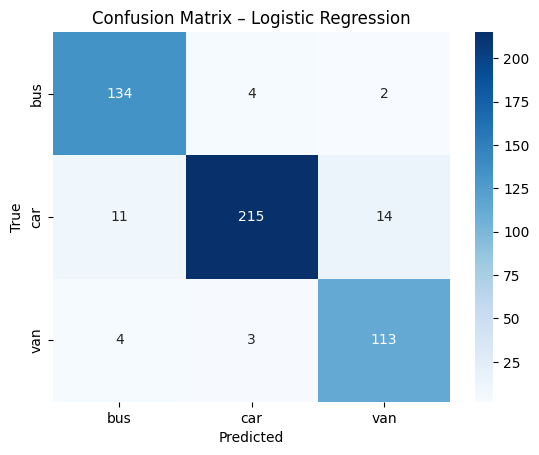

              precision    recall  f1-score   support

         bus       0.90      0.96      0.93       140
         car       0.97      0.90      0.93       240
         van       0.88      0.94      0.91       120

    accuracy                           0.92       500
   macro avg       0.91      0.93      0.92       500
weighted avg       0.93      0.92      0.92       500



In [106]:
# 📈 I determine the best model based on the highest F1 score
best_model_name = results_df.sort_values(by="F1 (macro)", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

# 📊 I import additional libraries for visualization and evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 📤 I create predictions with the best model
# Note: Logistic Regression and SVC require X_test_scaled!
if best_model_name in ["SVC", "Logistic Regression"]:
    y_pred = best_model.predict(X_test_scaled)
else:
    y_pred = best_model.predict(X_test)

# 📋 I create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 📊 I visualize the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# 🧾 I output a detailed classification performance report
print(classification_report(y_test, y_pred, target_names=le.classes_))


**Insights:**<br>

After removing highly correlated features, no performance gain was achieved with Logistic Regression — on the contrary, the accuracy slightly dropped to 93.4%. This shows that reducing redundant features does not automatically lead to better results. Some of these features may still contain complementary separation information that is relevant for linear models like Logistic Regression.
